In [6]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import Counter
from copy import deepcopy

import matplotlib.pyplot as plt

import os
import sys
from datetime import datetime, timedelta
sys.path.append(os.path.abspath('../../..'))
from utils.metrics import MAPE, MSE
from utils.db import get_db
from utils.rolling_mean import custom_rolling_mean

from visualizers import visualize_tree_pdf, visualize_tree_basic

In [7]:
engine = get_db()

In [8]:
yesterday = datetime.now() - timedelta(days=1)
print(f'yesterday: {yesterday.strftime('%m/%d/%Y')}')

yesterday: 06/17/2025


In [9]:
query = f"""
select sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('Sale')
    and item_ring_type in ('ITEM', 'SUBD')
    and sale_date between '1/1/2024' and '{yesterday.strftime('%m/%d/%Y')}'
group by sale_date
order by sale_date

"""

In [10]:
ds = pd.read_sql(query, engine)

2025-06-18 16:04:24,424 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-06-18 16:04:24,425 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-18 16:04:24,480 INFO sqlalchemy.engine.Engine select current_schema()
2025-06-18 16:04:24,480 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-18 16:04:24,537 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-06-18 16:04:24,537 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-18 16:04:24,594 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-18 16:04:24,595 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

## prep the data

In [11]:
ds['sale_date'] = pd.to_datetime(ds['sale_date'])
ds = ds.sort_values('sale_date').reset_index(drop=True)

### feature engineering

In [14]:
ds['trend'] = custom_rolling_mean(ds['sales'], window=7)
ds['day_of_week'] = ds['sale_date'].dt.dayofweek
ds['is_weekend'] = ds['day_of_week'].isin([5, 6]).astype(int)
ds['lag_1'] = ds['sales'].shift(1)
ds['lag_7'] = ds['sales'].shift(7)
ds['lag_mean_1_7'] = ds[['lag_1', 'lag_7']].mean(axis=1)

In [16]:
ds.head()

,sale_date,sales,trend,day_of_week,is_weekend,lag_1,lag_7,lag_mean_1_7
0,2024-02-22,26794.41,NaN,3,0,NaN,NaN,NaN
1,2024-02-23,32036.08,NaN,4,0,26794.41,NaN,26794.41
2,2024-02-24,27247.97,NaN,5,1,32036.08,NaN,32036.08
3,2024-02-25,32901.66,NaN,6,1,27247.97,NaN,27247.97
4,2024-02-26,24476.21,NaN,0,0,32901.66,NaN,32901.66


In [17]:
# drop na rows
ds_model = ds.dropna().reset_index(drop=True)

In [18]:
features = ['day_of_week', 'is_weekend', 'lag_1', 'lag_7', 'trend', 'lag_mean_1_7']
X = ds_model[features].values
y = ds_model['sales'].values

In [19]:
X.shape, y.shape, ds_model[features + ['sales']].head()

((473, 6),
 (473,),
    day_of_week  is_weekend     lag_1     lag_7         trend  lag_mean_1_7  \
 0            3           0  24238.68  26794.41  29610.214286     25516.545   
 1            4           0  31872.72  32036.08  29149.371429     31954.400   
 2            5           1  28810.18  27247.97  29448.677143     28029.075   
 3            6           1  29343.11  32901.66  29719.888571     31122.385   
 4            0           0  34800.14  24476.21  30301.155714     29638.175   
 
       sales  
 0  31872.72  
 1  28810.18  
 2  29343.11  
 3  34800.14  
 4  28545.08  )

### 😀 We should be set. Let's see what we have
- ✅ 473 samples
- ✅ 6 features
    - day_of_week, is_weekend, lag_1, lag_7, trend
- ✅ Target: sales

### Train Data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree Regressor

In [24]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_sample_split=2):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        result = np.array([self._predict_sample(x, self.tree) for x in X])
        return result
    
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or num_samples < self.min_sample_split:
            return np.mean(y)
        
        best_feat, best_thresh = self._best_split(X, y)
        if best_feat is None:
            return np.mean(y)
        
        left_mask = X[:, best_feat] <= best_thresh
        right_mask = X[:, best_feat] > best_thresh

        left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': best_feat, 'threshold': best_thresh, 'left': left, 'right': right}
    
    def _best_split(self, X, y):
        best_mse = float('inf')
        best_feat, best_thresh = None, None

        for feat in range(X.shape[1]):
            thresholds = np.unique(X[:, feat])
            for t in thresholds:
                left_mask = X[:, feat] <= t
                right_mask = X[:, feat] > t

                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue

                mse = self._calculate_mse(y[left_mask], y[right_mask])
                if mse < best_mse:
                    best_mse = mse
                    best_feat = feat
                    best_thresh = t

        return best_feat, best_thresh
    
    def _calculate_mse(self, left_y, right_y):
        left_mse = np.var(left_y) * len(left_y)
        right_mse = np.var(right_y) * len(right_y)
        return (left_mse + right_mse) / (len(left_y) + len(right_y))
    
    def _predict_sample(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node['feature']] <= node['threshold']:
            return self._predict_sample(x, node['left'])
        else:
            return self._predict_sample(x, node['right'])
        

        

## RandomForestRegressorFromScratch

In [22]:
class RandomForestRegressorFromScratch:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.feature_subsets = []

    def _get_feature_indices(self, n_features):
        if self.max_features == 'sqrt':
            return np.random.choice(n_features, int(np.sqrt(n_features)), replace=False)
        elif isinstance(self.max_features, int):
            return np.random.choice(n_features, self.max_features, replace=False)
        else:
            return np.arange(n_features)

    def fit(self, X, y):
        self.trees = []
        self.feature_subsets = []

        for _ in range(self.n_estimators):
            # Bootstrap sample
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]

            # Feature subset
            feature_idx = self._get_feature_indices(X.shape[1])
            self.feature_subsets.append(feature_idx)

            # Train tree
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_sample_split=self.min_samples_split
            )
            tree.fit(X_sample[:, feature_idx], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        preds = np.array([
            tree.predict(X[:, feat_idx]) for tree, feat_idx in zip(self.trees, self.feature_subsets)
        ])
        return np.mean(preds, axis=0)

    def feature_importances_(self, feature_names):
        # Count how often features were used across trees
        importances = Counter()
        total_splits = 0

        for tree, feat_idx in zip(self.trees, self.feature_subsets):
            stack = [tree.tree]
            while stack:
                node = stack.pop()
                if isinstance(node, dict):
                    importances[feature_names[feat_idx[node['feature']]]] += 1
                    total_splits += 1
                    stack.extend([node['left'], node['right']])

        # Normalize
        return {feat: count / total_splits for feat, count in importances.items()}



## Test

In [17]:
X_small = np.array([
    [1, 10],   # A
    [2, 20],   # B
    [3, 30],   # C
    [4, 40],   # D
    [5, 50]    # E
])
y_small = np.array([100, 200, 300, 400, 500]) 

In [ ]:
debug_tree = DecisionTreeRegressor(max_depth=2)
debug_tree.fit(X_small, y_small)

In [25]:
forest = RandomForestRegressorFromScratch(
    n_estimators=10,
    max_depth=6,
    max_features='sqrt'
)
forest.fit(X_train, y_train)

In [27]:
y_pred = forest.predict(X_test)
mse = MSE(y_test, y_pred)
mape = MAPE(y_test, y_pred)
print(f'Random Forest MSE: {mse:.2f}, MAPE: {(mape*100):.2f}%')

Random Forest MSE: 25796820.83, MAPE: 11.38%


In [28]:
importances = forest.feature_importances_(features)

In [29]:
importances

{'lag_mean_1_7': 0.21973094170403587,
 'trend': 0.2914798206278027,
 'lag_1': 0.13901345291479822,
 'day_of_week': 0.08520179372197309,
 'lag_7': 0.22869955156950672,
 'is_weekend': 0.03587443946188341}

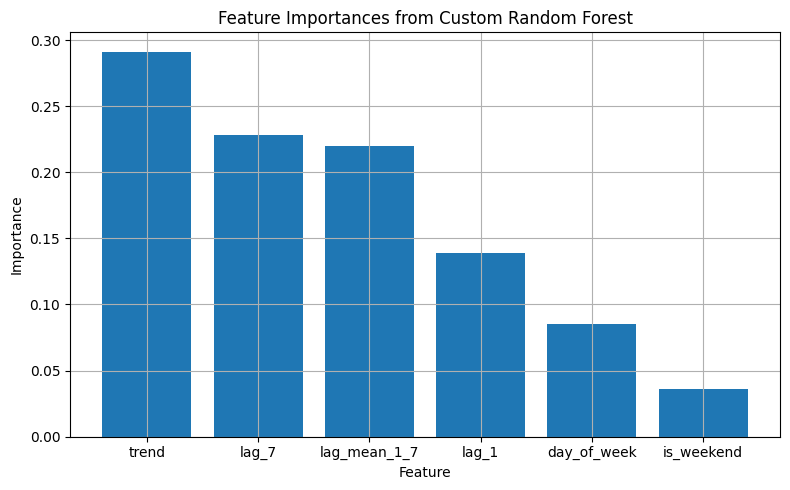

In [30]:
plt.figure(figsize=(8, 5))
sorted_items = sorted(importances.items(), key=lambda x: -x[1])
features_sorted, scores_sorted = zip(*sorted_items)

plt.bar(features_sorted, scores_sorted)
plt.title("Feature Importances from Custom Random Forest")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

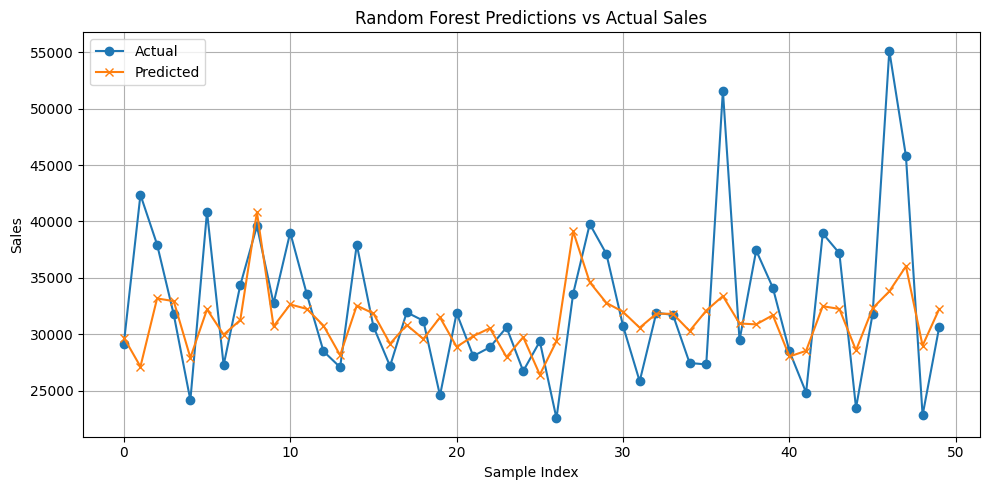

In [31]:
# --- Line Plot: Predictions vs Actuals ---
plt.figure(figsize=(10, 5))
plt.plot(y_test[:50], label='Actual', marker='o')
plt.plot(y_pred[:50], label='Predicted', marker='x')
plt.title("Random Forest Predictions vs Actual Sales")
plt.ylabel("Sales")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Visual all trees in the forest

In [36]:
# Visualize all trees from the forest and save them as separate PDFs
visualized_paths = []

for idx, tree_model in enumerate(forest.trees):
    dot = visualize_tree_pdf(tree_model.tree, feature_names=features)
    path = f"trees/forest_tree_{idx}.pdf"
    dot.render(path, format='pdf', cleanup=False)
    visualized_paths.append(path)

visualized_paths


['trees/forest_tree_0.pdf',
 'trees/forest_tree_1.pdf',
 'trees/forest_tree_2.pdf',
 'trees/forest_tree_3.pdf',
 'trees/forest_tree_4.pdf',
 'trees/forest_tree_5.pdf',
 'trees/forest_tree_6.pdf',
 'trees/forest_tree_7.pdf',
 'trees/forest_tree_8.pdf',
 'trees/forest_tree_9.pdf']

In [37]:
def hyperparameter_search(X, y, param_grid, metric='mape'):
    results = []

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for max_features in param_grid['max_features']:
                # Train/test split
                indices = np.arange(len(X))
                np.random.shuffle(indices)
                split = int(0.8 * len(X))
                train_idx, test_idx = indices[:split], indices[split:]
                X_train, y_train = X[train_idx], y[train_idx]
                X_test, y_test = X[test_idx], y[test_idx]

                # Train the model
                forest = RandomForestRegressorFromScratch(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_features
                )
                forest.fit(X_train, y_train)
                y_pred = forest.predict(X_test)

                # Calculate metrics
                mape = MAPE(y_test, y_pred)

                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'max_features': max_features,
                    'MAPE': mape
                })

    return results


In [39]:
param_grid = {
    'n_estimators': [3, 5, 7],
    'max_depth': [1, 2, 3],
    'max_features': ['sqrt', 1, 2]
}

In [40]:
search_results = hyperparameter_search(X_train, y_train, param_grid)

In [41]:
results_ds = pd.DataFrame(search_results)

In [43]:
results_ds.sort_values(by='MAPE', ascending=True)

,n_estimators,max_depth,max_features,MAPE
7,3,3,1,0.105492
16,5,3,1,0.105520
24,7,3,sqrt,0.112065
1,3,1,1,0.116658
17,5,3,2,0.116964
0,3,1,sqrt,0.124058
23,7,2,2,0.126110
10,5,1,1,0.126956
3,3,2,sqrt,0.131876
25,7,3,1,0.132544
